In [133]:
import pandas as pd
import numpy as np
import ssl
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import httplib2
ssl._create_default_https_context = ssl._create_unverified_context
response = urllib.request.urlopen('https://www.python.org')
import matplotlib.pyplot as plt

In [211]:
#create empty df with 24 episodes per season for 10 seasons
names = ['ross','chandler','joey','monica','phoebe','rachel']
df = pd.DataFrame(columns = names)
df['Season'],df['Episode'] = '',''
df['Season'] = seasons*len(episodes)
df['Episode'] = np.repeat(episodes,len(seasons))
df['Season'] = pd.to_numeric(df["Season"])
df['Episode'] = pd.to_numeric(df["Episode"])
df.sort_values(by=['Season', 'Episode'],inplace = True)
df.set_index(['Season','Episode'],inplace = True) #not sure if I want to keep this indexing

In [212]:
seasons = [num if len(num)==2 else '0'+num for num in np.arange(1,11).astype(str) ]
episodes = [num if len(num)==2 else '0'+num for num in np.arange(1,25).astype(str) ]

for season in seasons:
    print(season)
    for episode in episodes:
        url = "https://fangj.github.io/friends/season/"+season+episode+'.html'
        if season =='09' and episode == '23':
            url = 'https://fangj.github.io/friends/season/0923-0924.html'
        if season =='10' and episode =='17':
            url = 'https://fangj.github.io/friends/season/1017-1018.html'
        h = httplib2.Http()
        resp = h.request(url, 'HEAD')
        if int(resp[0]['status']) < 400:
            html = urlopen(url).read()
            soup = BeautifulSoup(html)
            # kill all script and style elements
            for script in soup(["script", "style"]):
                script.extract()    # rip it out
            # get text
            text = soup.get_text()
            # break into lines and remove leading and trailing space on each
            lines = (line.strip() for line in text.splitlines())
            # break multi-headlines into a line each
            chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
            # drop blank lines
            text = '\n'.join(chunk for chunk in chunks if chunk)
            
            
            names = ['ross','chandler','joey','monica','phoebe','rachel']
            d = dict.fromkeys(names,0)
            for line in text.split('\n'):
                if len(re.findall(r'^.*:',line)) >0:
                    starting = re.findall(r'^.*:',line)[0].split(':')[0].lower()
                    if starting in names:
                        l = re.sub(r'\([^)]*\)', '', line)
                        d[starting]+= len(l.split())-1
            df.loc[int(season),int(episode)] = d

01
02
03
04
05
06
07
08
09
10


In [238]:
df.dropna(thresh = 6,inplace=  True)
df

ross chandler joey monica phoebe rachel
Season Episode                                        
1      1        267      205  207    421    130    290
       2        466      155   55    185     92    273
       3        245      314  169    377    356    176
       4        247      186  122    242    165    263
       5        346      263  294    258    176    285
...             ...      ...  ...    ...    ...    ...
10     13       637      251  287    257    312    540
       14       445      261  482    299    411    429
       15       369      258  222    171    218    241
       16       505      386  242    597    288    494
       17       667      526  583    501    579    498

[224 rows x 6 columns]

In [279]:
from requests import get
url = 'https://www.imdb.com/title/tt0583459/?ref_=ttep_ep1'
response = get(url)
# print(response.text)

from bs4 import BeautifulSoup
# Initializing the series that the loop will populate
friends_episodes = []

# For every season in the series-- range depends on the show
for sn in range(1,11):
    # Request from the server the content of the web page by using get(), and store the server’s response in the variable response
    response = get('https://www.imdb.com/title/tt0108778/episodes?season=' + str(sn))

    # Parse the content of the request with BeautifulSoup
    page_html = BeautifulSoup(response.text, 'html.parser')

    # Select all the episode containers from the season's page
    episode_containers = page_html.find_all('div', class_ = 'info')

    # For each episode in each season
    for episodes in episode_containers:
            # Get the info of each episode on the page
            season = int(sn)
            episode_number = int(episodes.meta['content'])
            title = episodes.a['title']
            airdate = episodes.find('div', class_='airdate').text.strip()
            rating = episodes.find('span', class_='ipl-rating-star__rating').text
            total_votes = episodes.find('span', class_='ipl-rating-star__total-votes').text
            desc = episodes.find('div', class_='item_description').text.strip()
            # Compiling the episode info
            episode_data = [season, episode_number, title, airdate, rating, total_votes, desc]

            # Append the episode info to the complete dataset
            friends_episodes.append(episode_data)

In [280]:
ratings_df = pd.DataFrame(friends_episodes, columns = ['Season', 'Episode', 'title', 'airdate', 'rating', 'total_votes', 'desc'])
ratings_df.set_index(['Season','Episode'],inplace = True)

In [283]:
merged_df = df.merge(ratings_df,left_index = True,right_index=True,how='inner')

Text(0.5, 1.0, 'Correlation of episode rating to # words spoken')

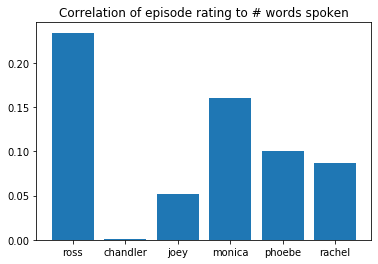

In [307]:
corrs = {}
for name in names:
    corrs[name]=np.corrcoef(merged_df[name].astype(int),merged_df['rating'].astype(float))[0,1]
plt.bar(list(corrs.keys()), list(corrs.values()))
plt.title('Correlation of episode rating to # words spoken')

In [315]:
ratings_df['rating'].astype(float).idxmin()

(4, 21)

In [324]:
ratings_df.loc[4,21]

title                                The One with the Invitation
airdate                                             23 Apr. 1998
rating                                                       7.2
total_votes                                              (3,570)
desc           As Ross and Emily send out wedding invitations...
Name: (4, 21), dtype: object

In [371]:
#look at each character's progression over 10 seasons ->
d = dict.fromkeys(names,[])

for season in range(1,11):
    season_df = merged_df.loc[season]
    for name in names:
        d[name] = d[name]+[(np.corrcoef(season_df[name].astype(int),season_df['rating'].astype(float))[0,1])]


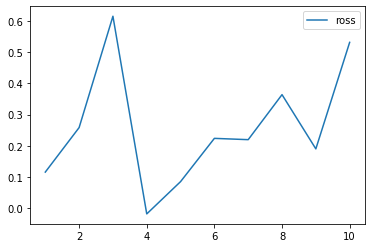

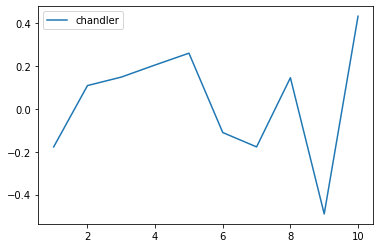

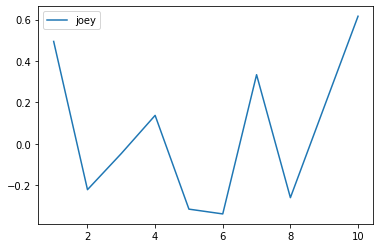

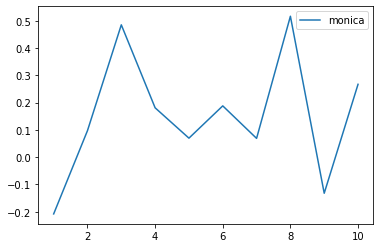

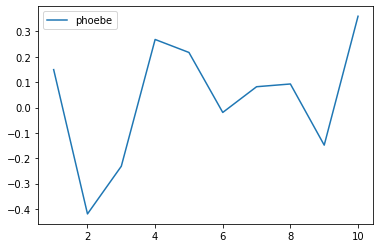

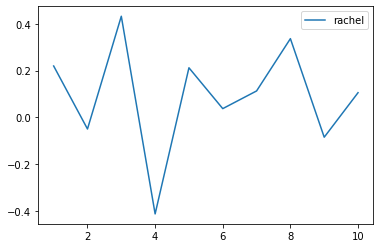

In [378]:
for name in names:
    plt.figure()
    plt.plot(np.arange(1,11),d[name],label = name)
    plt.legend()

In [345]:
d

{'ross': [0.11578322906190966,
  -0.17731522737533478,
  0.4946045054199065,
  -0.20789760891524375,
  0.14944869864048754,
  0.21983708739514493],
 'chandler': [0.11578322906190966,
  -0.17731522737533478,
  0.4946045054199065,
  -0.20789760891524375,
  0.14944869864048754,
  0.21983708739514493],
 'joey': [0.11578322906190966,
  -0.17731522737533478,
  0.4946045054199065,
  -0.20789760891524375,
  0.14944869864048754,
  0.21983708739514493],
 'monica': [0.11578322906190966,
  -0.17731522737533478,
  0.4946045054199065,
  -0.20789760891524375,
  0.14944869864048754,
  0.21983708739514493],
 'phoebe': [0.11578322906190966,
  -0.17731522737533478,
  0.4946045054199065,
  -0.20789760891524375,
  0.14944869864048754,
  0.21983708739514493],
 'rachel': [0.11578322906190966,
  -0.17731522737533478,
  0.4946045054199065,
  -0.20789760891524375,
  0.14944869864048754,
  0.21983708739514493]}

In [343]:
season_df[name].astype(int),season_df['rating'].astype(float)

(Episode
 1     290
 2     273
 3     176
 4     263
 5     285
 6     119
 7     249
 8     137
 9     305
 10    129
 11    136
 12    263
 13    207
 14    135
 15    182
 16    173
 17    360
 18    482
 19    437
 20    451
 21    221
 22    188
 23    154
 24    405
 Name: rachel, dtype: int64, Episode
 1     8.3
 2     8.1
 3     8.2
 4     8.1
 5     8.5
 6     8.1
 7     9.0
 8     8.1
 9     8.2
 10    8.1
 11    8.2
 12    8.2
 13    8.7
 14    8.3
 15    8.2
 16    8.2
 17    8.5
 18    8.8
 19    8.1
 20    7.9
 21    7.9
 22    8.3
 23    8.7
 24    8.9
 Name: rating, dtype: float64)

In [335]:
season_df

,ross,chandler,joey,monica,phoebe,rachel,title,airdate,rating,total_votes,desc
Episode,,,,,,,,,,,
1,426,254,272,277,321,372,The One After Joey and Rachel Kiss,25 Sep. 2003,8.5,"(3,304)",Joey and Ross both attempt to come clean to ea...
2,389,185,269,146,216,180,The One Where Ross Is Fine,2 Oct. 2003,8.8,"(3,584)",Rachel and Joey fear for Ross's state of mind ...
3,205,259,295,206,176,279,The One with Ross's Tan,9 Oct. 2003,8.8,"(3,476)",Ross goes to a tanning salon but fails to foll...
4,332,286,357,299,237,406,The One with the Cake,23 Oct. 2003,8.3,"(2,998)","On Emma's first birthday, Ross and Rachel conv..."
5,245,192,278,224,278,492,The One Where Rachel's Sister Babysits,30 Oct. 2003,8.2,"(2,989)",Rachel's sister Amy comes to visit and moves i...
6,337,213,213,172,194,215,The One with Ross' Grant,6 Nov. 2003,8.2,"(3,028)",Ross applies for a paleontology grant and find...
7,305,289,194,291,339,256,The One with the Home Study,13 Nov. 2003,8.3,"(2,883)",Monica and Chandler nervously prepare for a vi...
8,384,545,527,524,495,517,The One with the Late Thanksgiving,20 Nov. 2003,8.9,"(3,517)","Joey, Ross, Rachel and Phoebe convince Monica ..."
9,295,484,503,431,262,312,The One with the Birth Mother,8 Jan. 2004,8.6,"(3,045)",After Rachel confirms Joey is more mature in r...


In [359]:
for name in names:
    print(d[name])

[]
[]
[]
[]
[]
[]


In [382]:
merged_df.to_excel('ratings.xlsx')

In [381]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 1.7 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8915 sha256=6ba8d7d136d1fe2ea2e917a2fefd35ca53e4788f7fa0065900ad844409cba458
  Stored in directory: /Users/chandak_rishabh/Library/Caches/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
